In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# have to uv pip install abtem, not wanting it as a dependency 
import abtem
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from abtem.atoms import orthogonalize_cell
from ase.build import graphene
from quantem.core import config
from quantem.core.ml.splat.datasets import SimpleImageDataset, SimpleVolumeDataset
from quantem.core.ml.splat.gs import GS
from quantem.core.ml.splat.gs_config import Config
from quantem.core.visualization import show_2d

config.set({"device": "cuda:0"})
print(config.get("device"))


cuda:2


# TODO 
- quantem config for gpus

# Image splatting (2D) -- trilayer graphene 

## simulating the potential

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='y [Å]', ylabel='z [Å]'>)

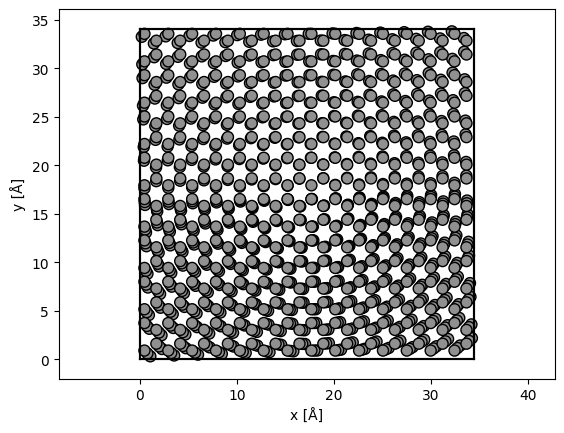

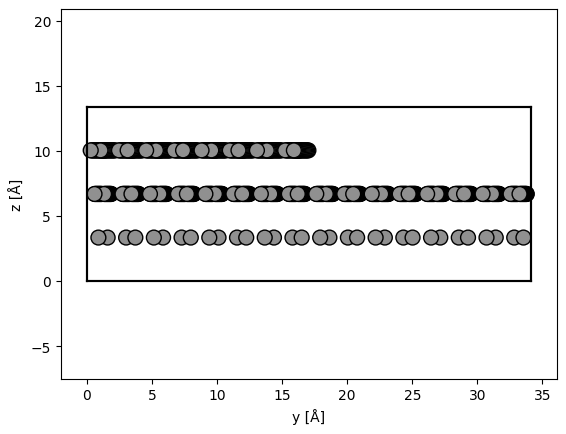

In [3]:
a = 2.504  # Lattice constant of hBN
twist_angle = 1  # Twist angle in degrees
interlayer_distance = 3.35  # Interlayer distance in Ångströms

layer1 = graphene(vacuum=interlayer_distance*2)
layer2 = graphene(vacuum=interlayer_distance*2)
layer3 = graphene(vacuum=interlayer_distance*2)
layer1 = orthogonalize_cell(layer1)
layer2 = orthogonalize_cell(layer2)
layer3 = orthogonalize_cell(layer3)

layer1 *= [14,8,1]
layer2 *= [14,8,1]
layer3 *= [14,4,1]

layer2.rotate(twist_angle,'z',  center=[layer1.cell[0,0]/2, layer1.cell[1,1]/2, 0])
layer3.rotate(twist_angle*2,'z', center=[layer1.cell[0,0]/2, layer1.cell[1,1]/2, 0])

layer2.translate([0,0,interlayer_distance])
layer3.translate([0,0,interlayer_distance*2])

trilayer_graphene = layer1+layer2+layer3
trilayer_graphene.center()

abtem.show_atoms(trilayer_graphene)
abtem.show_atoms(trilayer_graphene, plane='yz')

(<Figure size 1200x400 with 6 Axes>,
 array([<Axes: title={'center': '1 frozen phonons potential'}>,
        <Axes: title={'center': 'zoom center'}>,
        <Axes: title={'center': 'zoom corner'}>], dtype=object))

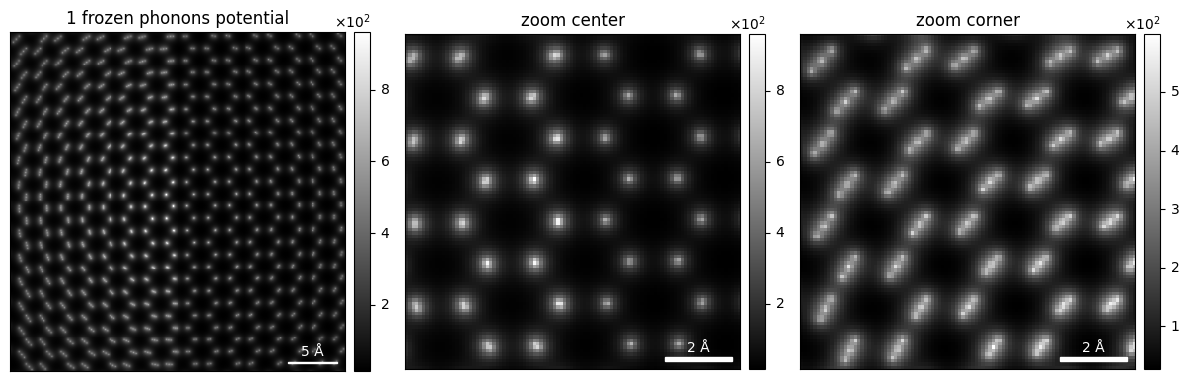

In [4]:
num_configs = 1 

phonons = abtem.FrozenPhonons(
    trilayer_graphene,
    num_configs, 
    sigmas=0.01,
    seed=42,
)
potential = abtem.Potential(
    phonons,
    sampling=0.1,
    slice_thickness=0.5,
    parametrization='kirkland',
    projection='infinite',
    device='cpu',
)

pot3d = potential.build().array.sum(0).compute()
pot2d = pot3d.sum(0) 
cy, cx = pot2d.shape[0] // 2, pot2d.shape[1] // 2

show_2d(
    [
        pot2d, pot2d[cy-50:cy+50, cx-50:cx+50,], pot2d[:100, :100],
    ],
    title=[f'{num_configs} frozen phonons potential', 'zoom center', 'zoom corner'],
    cbar=True,
    norm='minmax',
    sampling=potential.sampling,
)


## splatting 2D (just fitting to an image)
- image fitting (i.e. not doing tomography or using the radon forward) is a feature/tool we will still want as it will be super useful for (S)TEM imaging applications

(<Figure size 400x400 with 2 Axes>, <Axes: title={'center': 'Potential'}>)

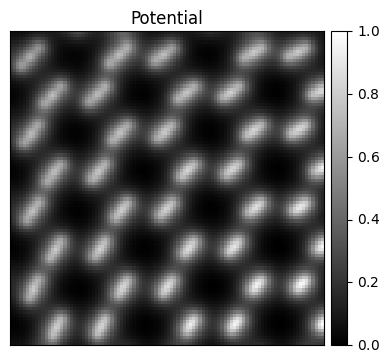

In [5]:
# im = pot2d.copy()
# im:np.ndarray = pot2d[:100, :150].copy()
im = pot2d[:100, :100].copy()
# im = pot2d[:200, :400].copy()
im = ndi.gaussian_filter(im, sigma=1)
im -= im.min()
im /= im.max()
show_2d(im, norm='minmax', cbar=True, title='Potential')


Model initialized. Number of GS: 81


  0%|          | 0/15000 [00:00<?, ?it/s]

/home/amccray/code/quantem/src/quantem/core/ml/splat/gs.py:277: UserWarning: Using a target size (torch.Size([1, 100, 100])) that is different to the input size (torch.Size([1, 1, 100, 100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  l2loss = F.mse_loss(renders, images)


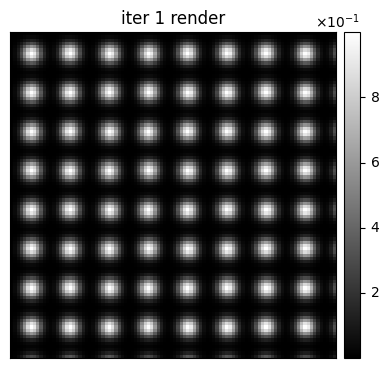

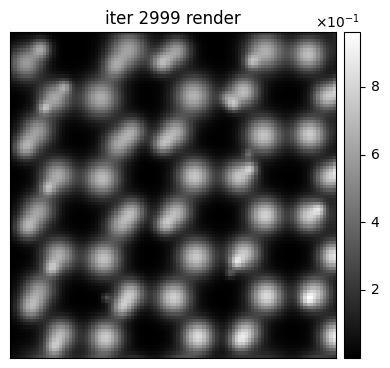

grads pos max: 1.99e-03, mean: 6.76e-04, min: 2.38e-06, std: 5.00e-04
grads_sigmas max: 1.23e-02, mean: 4.13e-03, min: 8.21e-05, std: 3.51e-03
grads ave max: 6.77e-03, mean: 2.40e-03, min: 1.14e-04, std: 1.82e-03
Step 3000 dupli/split: 2 GSs duplicated, 20 GSs split. Now have 103 GSs.
Step 3000 merge: 0 events | Now have 103 GSs.
Step 3000 pruned: total: 13 | intensity: 0 | big: 0 | small: 3 | xyz: 10
Step 3000 prune: 13 GSs | Now have 90 GSs.


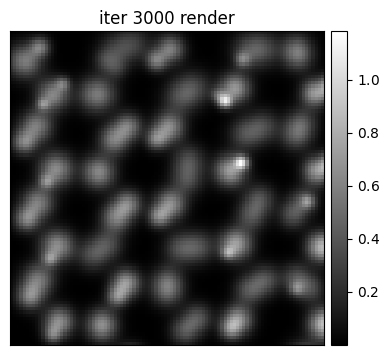

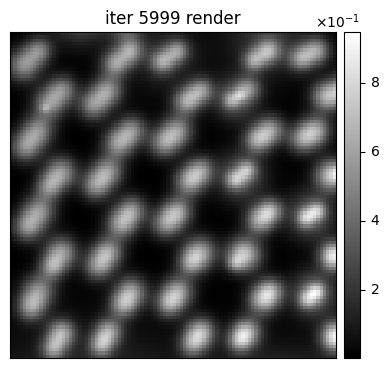

grads pos max: 2.15e-04, mean: 5.28e-05, min: 3.71e-06, std: 3.47e-05
grads_sigmas max: 6.81e-04, mean: 3.05e-04, min: 3.73e-05, std: 1.50e-04
grads ave max: 3.69e-04, mean: 1.79e-04, min: 2.62e-05, std: 8.33e-05
Step 6000 dupli/split: 0 GSs duplicated, 0 GSs split. Now have 90 GSs.
Step 6000 merge: 0 events | Now have 90 GSs.
Step 6000 pruned: total: 4 | intensity: 0 | big: 2 | small: 1 | xyz: 3
Step 6000 prune: 4 GSs | Now have 86 GSs.
Step 6000 reset intensities and sigmas


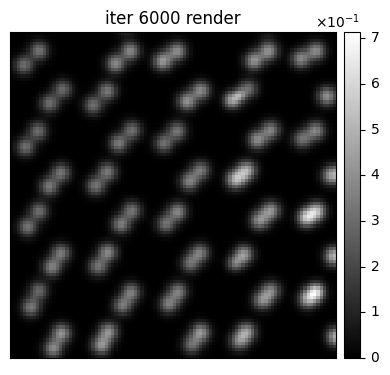

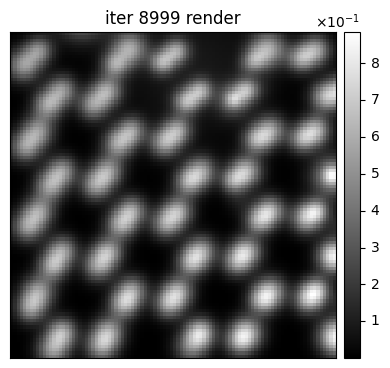

grads pos max: 1.93e-04, mean: 6.82e-05, min: 1.74e-05, std: 2.79e-05
grads_sigmas max: 2.35e-03, mean: 1.51e-03, min: 2.55e-04, std: 4.24e-04
grads ave max: 1.20e-03, mean: 7.87e-04, min: 1.40e-04, std: 2.16e-04
Step 9000 dupli/split: 0 GSs duplicated, 0 GSs split. Now have 86 GSs.
Step 9000 merge: 2 events | Now have 84 GSs.
Step 9000 pruned: total: 7 | intensity: 6 | big: 1 | small: 0 | xyz: 1
Step 9000 prune: 7 GSs | Now have 77 GSs.


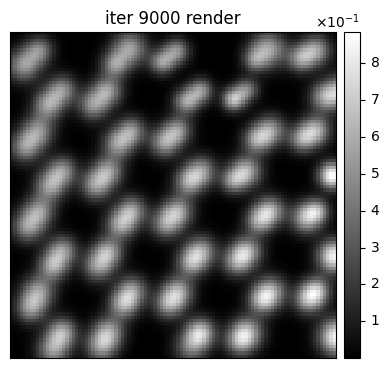

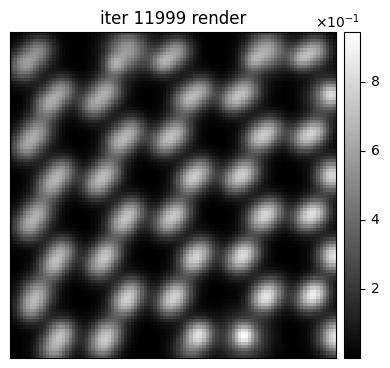

grads pos max: 1.40e-04, mean: 8.28e-05, min: 2.20e-05, std: 2.60e-05
grads_sigmas max: 5.14e-04, mean: 9.24e-05, min: 4.25e-06, std: 1.06e-04
grads ave max: 2.88e-04, mean: 8.76e-05, min: 1.31e-05, std: 5.11e-05
Step 12000 dupli/split: 0 GSs duplicated, 0 GSs split. Now have 77 GSs.
Step 12000 merge: 1 events | Now have 76 GSs.
Step 12000 pruned: total: 0 | intensity: 0 | big: 0 | small: 0 | xyz: 0
Step 12000 prune: 0 GSs | Now have 76 GSs.


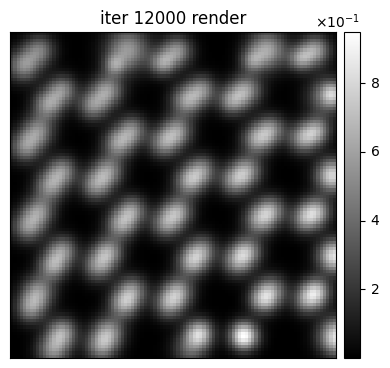

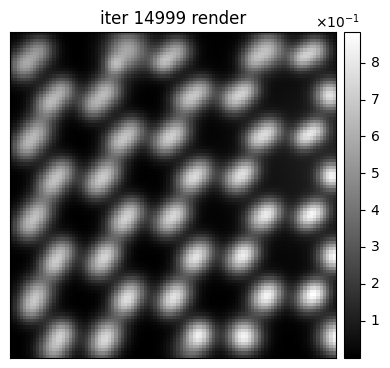

grads pos max: 2.02e-04, mean: 1.16e-04, min: 2.79e-05, std: 2.71e-05
grads_sigmas max: 3.00e-04, mean: 2.95e-05, min: 2.91e-06, std: 4.60e-05
grads ave max: 1.88e-04, mean: 7.27e-05, min: 2.88e-05, std: 2.24e-05
Step 15000 dupli/split: 0 GSs duplicated, 0 GSs split. Now have 76 GSs.
Step 15000 merge: 0 events | Now have 76 GSs.
Step 15000 pruned: total: 1 | intensity: 1 | big: 1 | small: 0 | xyz: 0
Step 15000 prune: 1 GSs | Now have 75 GSs.


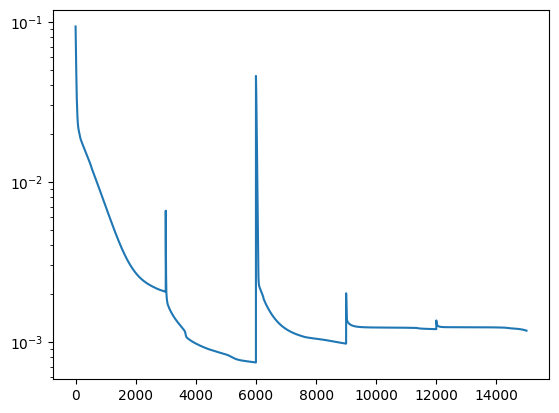

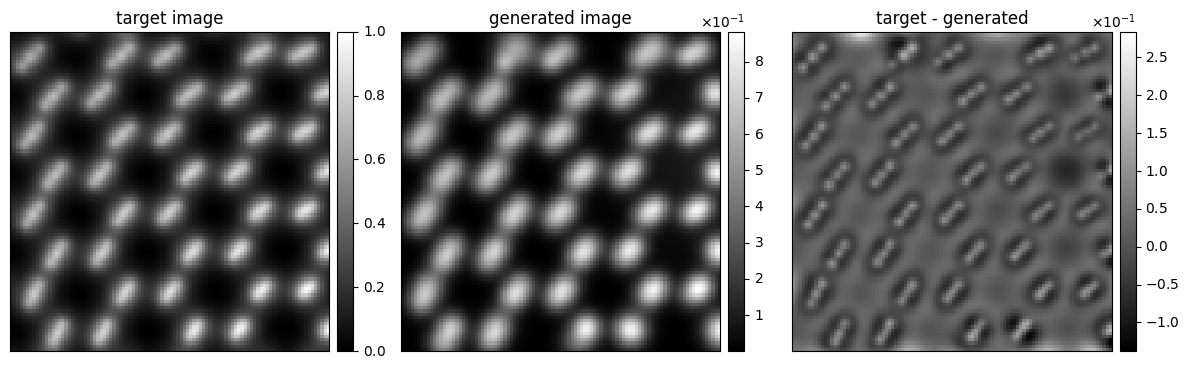

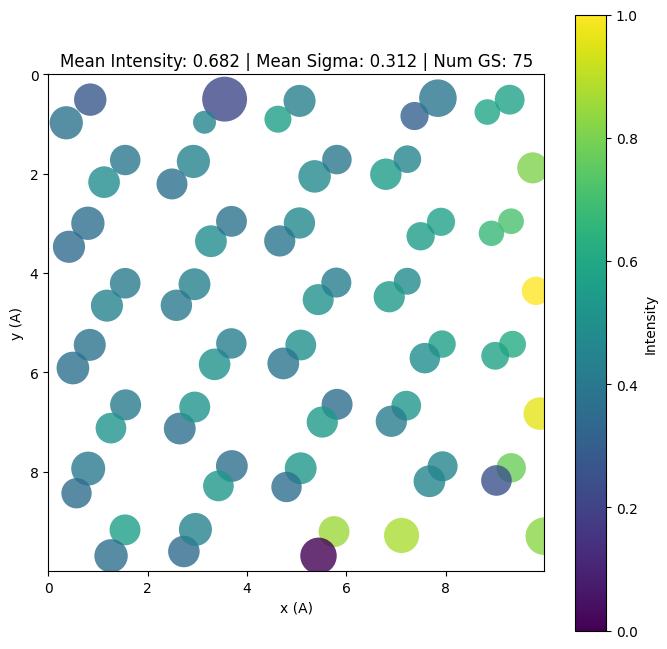

In [6]:
plt.close('all')
# _cell = np.diag(trilayer_graphene.cell.array) # x,y,z
# _cell = (_cell[2], _cell[1], _cell[0])  # z,y,x 
_cell = (0, potential.sampling[1] * im.shape[0], potential.sampling[0] * im.shape[1])  # z,y,x

# TODO add a shrinkage option 

cfg = Config(
    model_type = '2dgs', 
    volume_size = _cell, 
    raster_shape=(im.shape[0], im.shape[1]),
    isotropic_splats=True,
    # 
    max_steps = 15_000, # 20_000,
    init_grid_sampling = 1.2, # 1.7, #  0.9, # A
    refine_start_iter = 3_000, # 5_000, 
    # refine_stop_iter = 16_000, 
    refine_every = 3000, 
    reset_every = 6000, 
    # add_start_iter = 15_000,
    # add_stop_iter = 15_500,
    lr_base = 0.01,  # 5e-3
    init_intensity= 1, # im.max(),
    init_sigma=0.2,
    prune_intensity_fac=0.15,
    prune_sigma_big_A= 1., # 1
    prune_sigma_small_A =0.12, # 0.15
    prune_pad_A= 0.5,
    xy_merge_A = 0.1, # 0.25
    xy_merge_sigma_fac = 0.9, 
    split_dup_grad2d=0.003, 
    device=config.get("device"),
)

dset = SimpleImageDataset(im)

gs = GS(
    cfg, 
)

pred, losses = gs.fit_image(dset, max_steps=cfg.max_steps)

fig, ax = plt.subplots()
ax.semilogy(losses)
plt.show()

show_2d(
    [
        im, pred, im-pred,
    ],
    title=['target image', 'generated image', 'target - generated'],
    cbar=True,
    norm='minmax',
)
gs.plot_gaussians()


Model initialized. Number of GS: 493


  0%|          | 0/15000 [00:00<?, ?it/s]

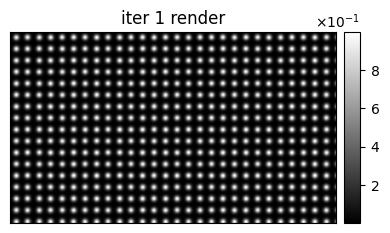

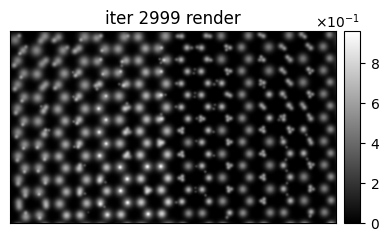

grads pos:  tensor(0.0008, device='cuda:1', dtype=torch.float64) tensor(0.0002, device='cuda:1', dtype=torch.float64) tensor(3.2880e-07, device='cuda:1', dtype=torch.float64) tensor(0.0002, device='cuda:1', dtype=torch.float64)
grads_sigmas :  tensor(0.0048, device='cuda:1', dtype=torch.float64) tensor(0.0019, device='cuda:1', dtype=torch.float64) tensor(3.8259e-05, device='cuda:1', dtype=torch.float64) tensor(0.0012, device='cuda:1', dtype=torch.float64)
grads ave:  tensor(0.0024, device='cuda:1', dtype=torch.float64) tensor(0.0010, device='cuda:1', dtype=torch.float64) tensor(2.1937e-05, device='cuda:1', dtype=torch.float64) tensor(0.0006, device='cuda:1', dtype=torch.float64)
Step 3000 dupli/split: 0 GSs duplicated, 0 GSs split. Now have 493 GSs.
Step 3000 merge: 13 events | Now have 480 GSs.
Step 3000 pruned: total: 72 | intensity: 0 | big: 1 | small: 42 | xy: 30
Step 3000 prune: 72 GSs | Now have 408 GSs.


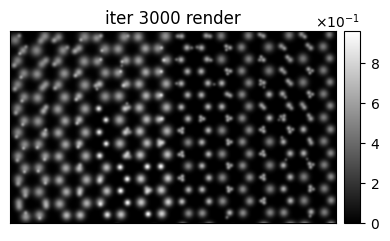

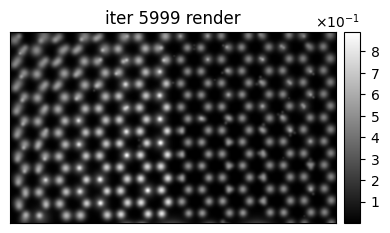

grads pos:  tensor(6.6544e-05, device='cuda:1', dtype=torch.float64) tensor(4.4680e-06, device='cuda:1', dtype=torch.float64) tensor(3.3540e-09, device='cuda:1', dtype=torch.float64) tensor(7.1901e-06, device='cuda:1', dtype=torch.float64)
grads_sigmas :  tensor(0.0006, device='cuda:1', dtype=torch.float64) tensor(0.0002, device='cuda:1', dtype=torch.float64) tensor(2.6267e-06, device='cuda:1', dtype=torch.float64) tensor(0.0001, device='cuda:1', dtype=torch.float64)
grads ave:  tensor(0.0003, device='cuda:1', dtype=torch.float64) tensor(8.2572e-05, device='cuda:1', dtype=torch.float64) tensor(1.8967e-06, device='cuda:1', dtype=torch.float64) tensor(6.9901e-05, device='cuda:1', dtype=torch.float64)
Step 6000 dupli/split: 0 GSs duplicated, 0 GSs split. Now have 408 GSs.
Step 6000 merge: 21 events | Now have 385 GSs.
Step 6000 pruned: total: 37 | intensity: 21 | big: 2 | small: 26 | xy: 7
Step 6000 prune: 37 GSs | Now have 348 GSs.
Step 6000 reset intensities and sigmas


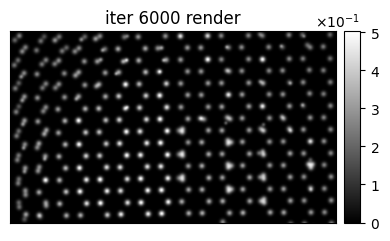

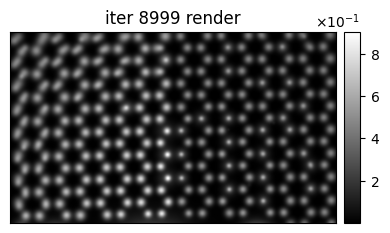

grads pos:  tensor(7.3801e-05, device='cuda:1', dtype=torch.float64) tensor(1.3537e-05, device='cuda:1', dtype=torch.float64) tensor(7.4229e-07, device='cuda:1', dtype=torch.float64) tensor(9.2719e-06, device='cuda:1', dtype=torch.float64)
grads_sigmas :  tensor(0.0015, device='cuda:1', dtype=torch.float64) tensor(0.0006, device='cuda:1', dtype=torch.float64) tensor(7.8883e-06, device='cuda:1', dtype=torch.float64) tensor(0.0004, device='cuda:1', dtype=torch.float64)
grads ave:  tensor(0.0008, device='cuda:1', dtype=torch.float64) tensor(0.0003, device='cuda:1', dtype=torch.float64) tensor(8.1772e-06, device='cuda:1', dtype=torch.float64) tensor(0.0002, device='cuda:1', dtype=torch.float64)
Step 9000 dupli/split: 0 GSs duplicated, 0 GSs split. Now have 348 GSs.
Step 9000 merge: 24 events | Now have 320 GSs.
Step 9000 pruned: total: 11 | intensity: 7 | big: 3 | small: 1 | xy: 4
Step 9000 prune: 11 GSs | Now have 309 GSs.


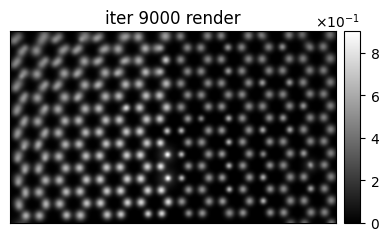

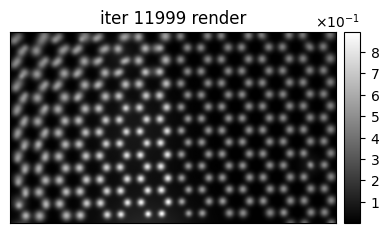

grads pos:  tensor(5.1139e-05, device='cuda:1', dtype=torch.float64) tensor(2.1063e-05, device='cuda:1', dtype=torch.float64) tensor(1.5560e-06, device='cuda:1', dtype=torch.float64) tensor(1.2121e-05, device='cuda:1', dtype=torch.float64)
grads_sigmas :  tensor(0.0018, device='cuda:1', dtype=torch.float64) tensor(4.0730e-05, device='cuda:1', dtype=torch.float64) tensor(1.2047e-06, device='cuda:1', dtype=torch.float64) tensor(0.0001, device='cuda:1', dtype=torch.float64)
grads ave:  tensor(0.0009, device='cuda:1', dtype=torch.float64) tensor(3.0897e-05, device='cuda:1', dtype=torch.float64) tensor(2.0076e-06, device='cuda:1', dtype=torch.float64) tensor(6.5451e-05, device='cuda:1', dtype=torch.float64)
Step 12000 dupli/split: 0 GSs duplicated, 0 GSs split. Now have 309 GSs.
Step 12000 merge: 2 events | Now have 307 GSs.
Step 12000 pruned: total: 4 | intensity: 2 | big: 3 | small: 0 | xy: 2
Step 12000 prune: 4 GSs | Now have 303 GSs.
Step 12000 reset intensities and sigmas


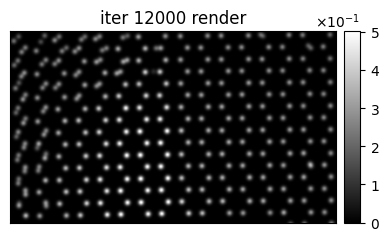

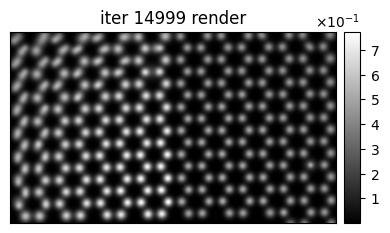

grads pos:  tensor(5.8521e-05, device='cuda:1', dtype=torch.float64) tensor(2.4841e-05, device='cuda:1', dtype=torch.float64) tensor(3.3753e-06, device='cuda:1', dtype=torch.float64) tensor(1.2490e-05, device='cuda:1', dtype=torch.float64)
grads_sigmas :  tensor(0.0015, device='cuda:1', dtype=torch.float64) tensor(0.0007, device='cuda:1', dtype=torch.float64) tensor(0.0001, device='cuda:1', dtype=torch.float64) tensor(0.0004, device='cuda:1', dtype=torch.float64)
grads ave:  tensor(0.0007, device='cuda:1', dtype=torch.float64) tensor(0.0003, device='cuda:1', dtype=torch.float64) tensor(7.0163e-05, device='cuda:1', dtype=torch.float64) tensor(0.0002, device='cuda:1', dtype=torch.float64)
Step 15000 dupli/split: 0 GSs duplicated, 0 GSs split. Now have 303 GSs.
Step 15000 merge: 1 events | Now have 302 GSs.
Step 15000 pruned: total: 0 | intensity: 0 | big: 0 | small: 0 | xy: 0
Step 15000 prune: 0 GSs | Now have 302 GSs.


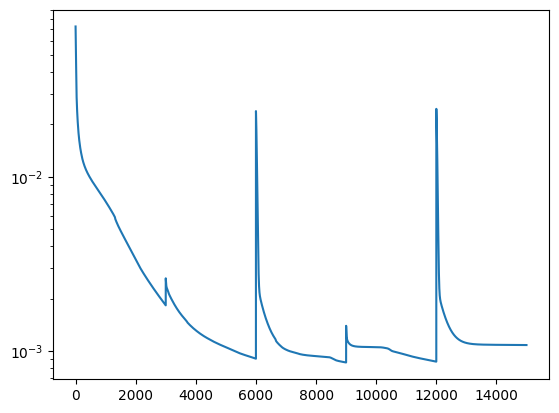

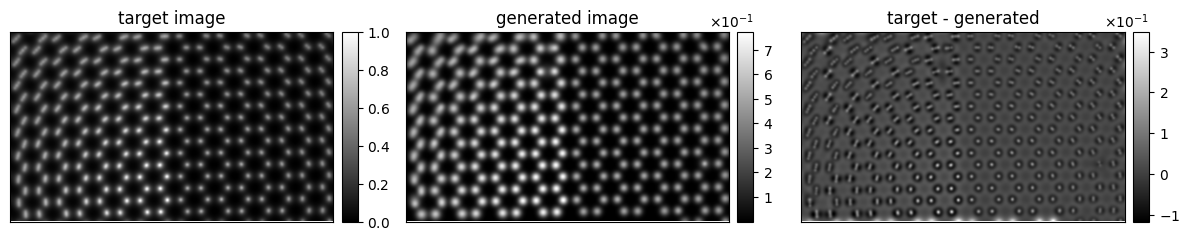

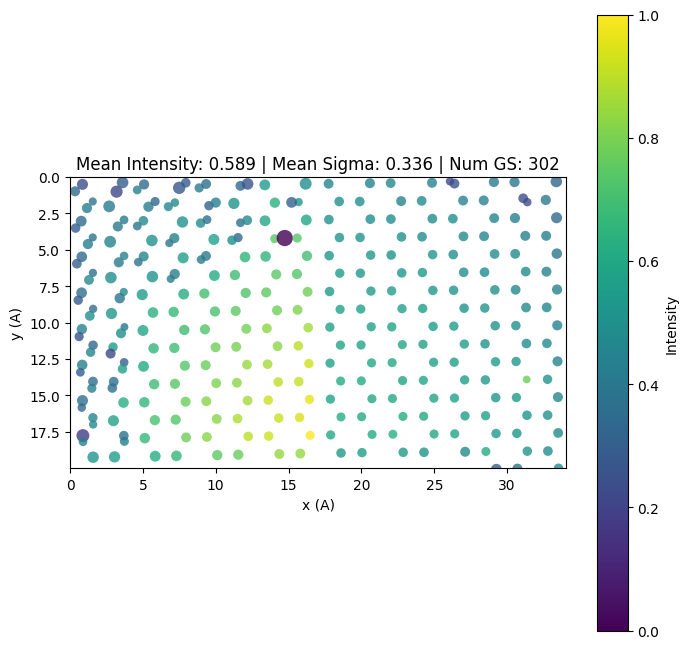

In [ ]:
# plt.close('all')
# # _cell = np.diag(trilayer_graphene.cell.array) # x,y,z
# # _cell = (_cell[2], _cell[1], _cell[0])  # z,y,x 
# _cell = (0, potential.sampling[1] * im.shape[0], potential.sampling[0] * im.shape[1])  # z,y,x

# # TODO add a shrinkage option 

# cfg = Config(
#     model_type = '2dgs', 
#     volume_size = _cell, 
#     raster_shape=(im.shape[0], im.shape[1]),
#     isotropic_splats=True,
#     # 
#     max_steps = 15_000, # 20_000,
#     init_grid_sampling = 1.2, # 1.7, #  0.9, # A
#     refine_start_iter = 3_000, # 5_000, 
#     # refine_stop_iter = 16_000, 
#     refine_every = 3000, 
#     reset_every = 6000, 
#     # add_start_iter = 15_000,
#     # add_stop_iter = 15_500,
#     lr_base = 0.01,  # 5e-3
#     init_intensity= 1, # im.max(),
#     init_sigma=0.2,
#     prune_intensity_fac=0.15,
#     prune_sigma_big_A= 1., # 1
#     prune_sigma_small_A =0.12, # 0.15
#     prune_pad_A= 0.5,
#     xy_merge_A = 0.1, # 0.25
#     xy_merge_sigma_fac = 0.9, 
#     split_dup_grad2d=0.003, 
#     device=config.get("device"),
# )

# dset = SimpleImageDataset(im)

# gs = GS(
#     cfg, 
#     dset,
# )

# pred, losses = gs.fit_image()

# fig, ax = plt.subplots()
# ax.semilogy(losses)
# plt.show()

# show_2d(
#     [
#         im, pred, im-pred,
#     ],
#     title=['target image', 'generated image', 'target - generated'],
#     cbar=True,
#     norm='minmax',
# )
# gs.plot_gaussians()


# 3D volume fitting (identity, not doing tomo)

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='x [Å]', ylabel='z [Å]'>)

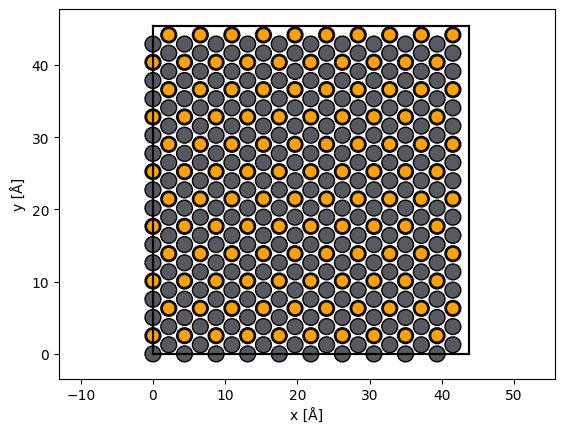

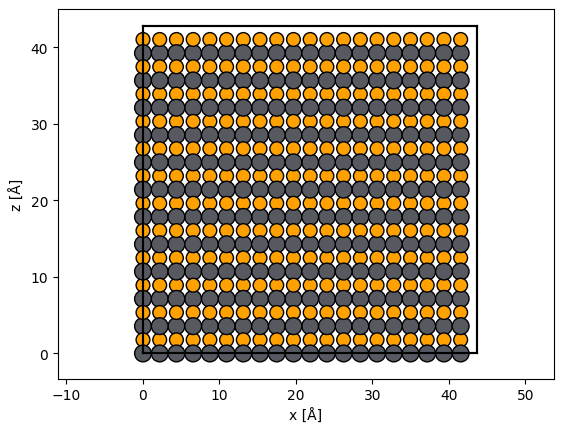

In [7]:
import ase

pbse = ase.io.read("../data/PbSe_cubic_mp-2201.cif")
pbse = orthogonalize_cell(pbse)
pbse *= [10,6,4]
abtem.show_atoms(pbse, plane='xy')
abtem.show_atoms(pbse, plane='xz')


(<Figure size 800x400 with 4 Axes>,
 array([<Axes: title={'center': '1 frozen phonons potential'}>,
        <Axes: title={'center': 'zoom center'}>], dtype=object))

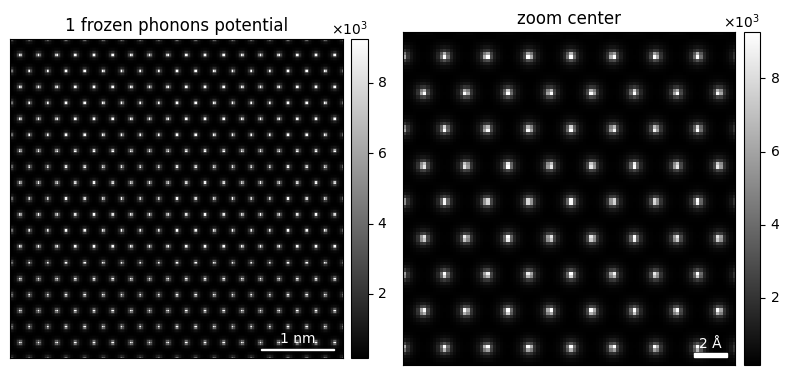

In [8]:
num_configs = 1 

phonons = abtem.FrozenPhonons(
    pbse,
    num_configs, 
    sigmas=0.01,
    seed=42,
)
potential = abtem.Potential(
    phonons,
    sampling=0.2,
    slice_thickness=0.2,
    parametrization='kirkland',
    projection='finite',
    device='cpu',
)

pot3d = potential.build().array.sum(0).compute()
pot2d = pot3d.sum(0) 
cy, cx = pot2d.shape[0] // 2, pot2d.shape[1] // 2

show_2d(
    [
        pot2d, pot2d[cy-50:cy+50, cx-50:cx+50,],
    ],
    title=[f'{num_configs} frozen phonons potential', 'zoom center'],
    cbar=True,
    norm='minmax',
    sampling=potential.sampling,
)


(<Figure size 1200x400 with 6 Axes>,
 array([<Axes: title={'center': 'Potential (yx) sum'}>,
        <Axes: title={'center': 'Potential (zx) sum'}>,
        <Axes: title={'center': 'Potential (zx) slice'}>], dtype=object))

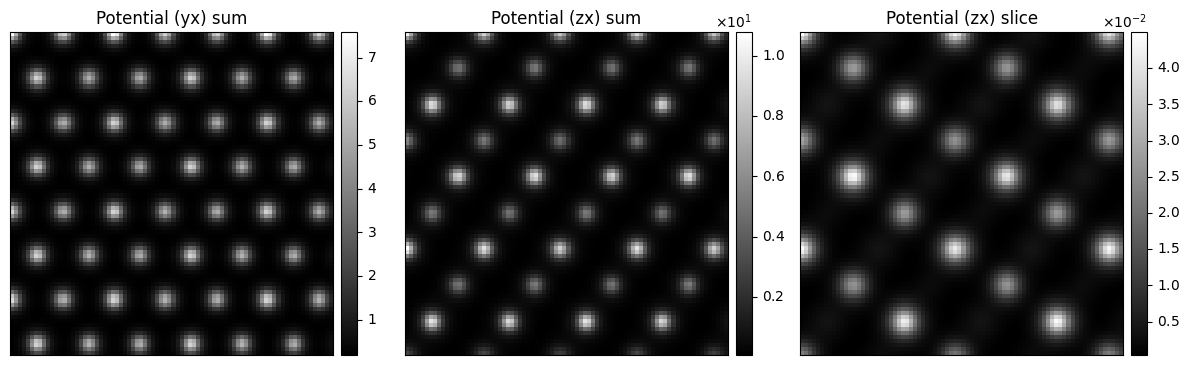

In [9]:
# vol = pot3d.copy()
# vol:np.ndarray = pot3d[:100, :150].copy()
vol = pot3d[:80, :80, :80].copy()
# vol = pot3d[:200, :400].copy()
vol = ndi.gaussian_filter(vol, sigma=1)
vol -= vol.min()
vol /= vol.max()
show_2d(
    [
        vol.sum(0),
        vol.sum(1),
        vol[:, vol.shape[1]//2, :],
    ],
    norm="minmax",
    cbar=True,
    title=["Potential (yx) sum", "Potential (zx) sum", "Potential (zx) slice"],
)

Model initialized. Number of GS: 512


  0%|          | 0/5000 [00:00<?, ?it/s]

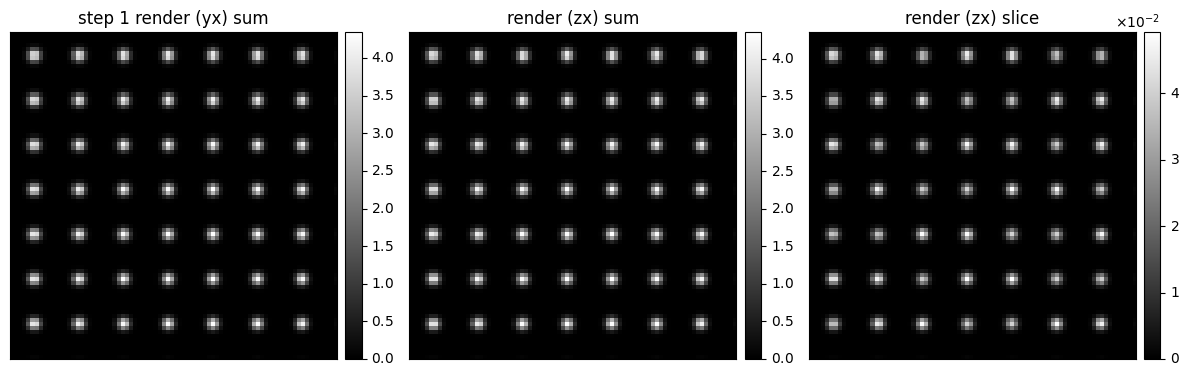

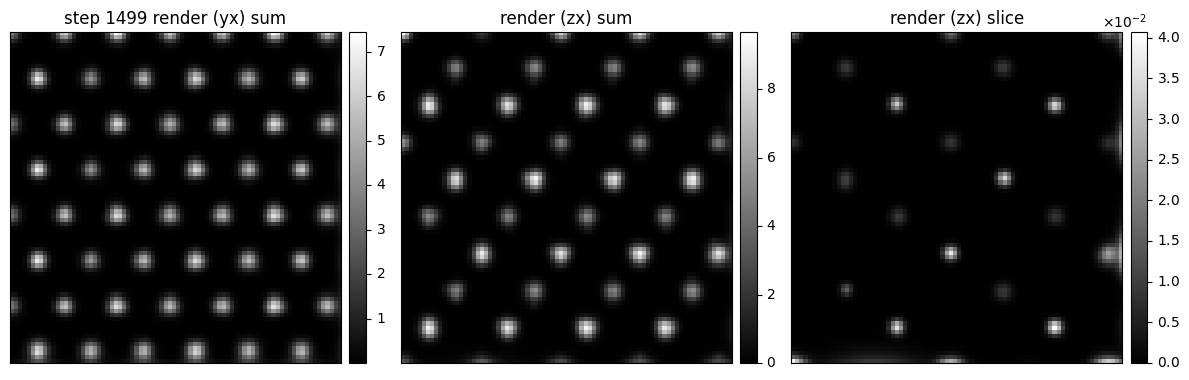

grads pos max: 1.53e-05, mean: 3.24e-06, min: 2.93e-09, std: 2.88e-06
grads_sigmas max: 1.62e-04, mean: 1.98e-05, min: 3.42e-08, std: 1.96e-05
grads ave max: 8.57e-05, mean: 1.15e-05, min: 2.27e-08, std: 1.09e-05
Step 1500 dupli/split: 49 GSs duplicated, 229 GSs split. Now have 790 GSs.
Step 1500 merge: 2 events | Now have 788 GSs.
Step 1500 pruned: total: 129 | intensity: 0 | big: 3 | small: 0 | xyz: 129
Step 1500 prune: 129 GSs | Now have 659 GSs.


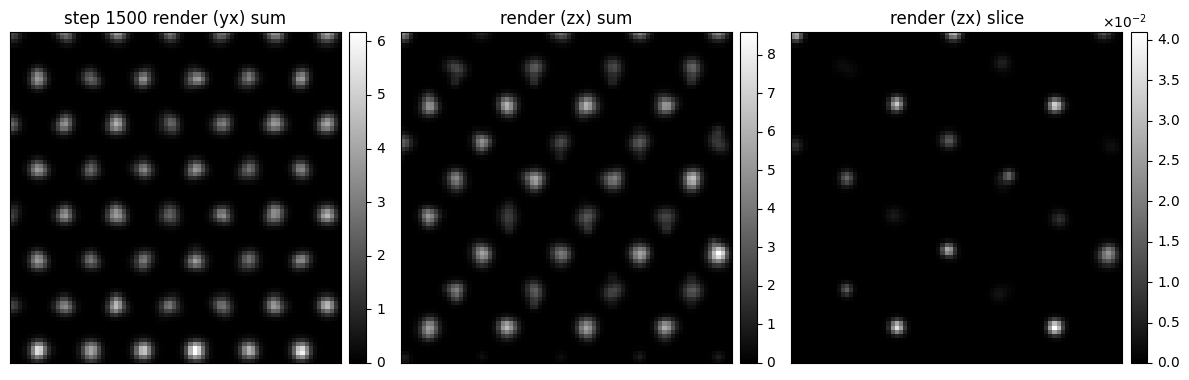

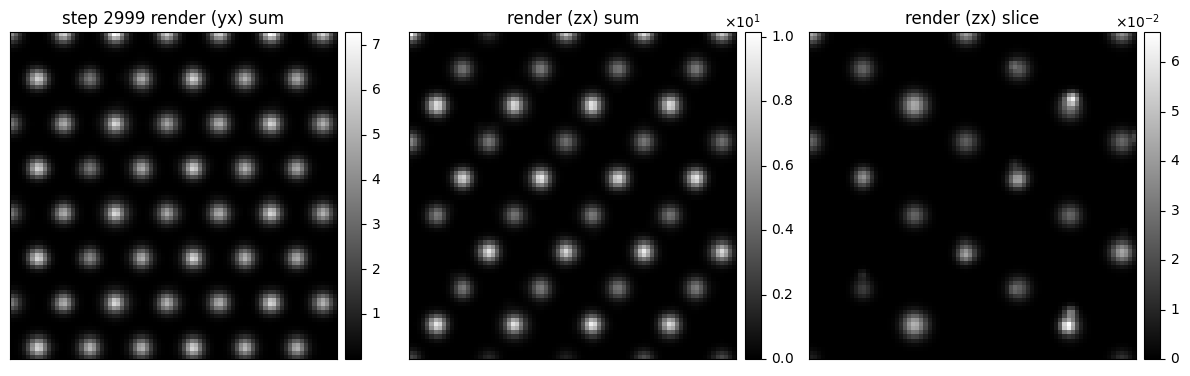

grads pos max: 3.88e-06, mean: 5.40e-07, min: 7.66e-09, std: 4.34e-07
grads_sigmas max: 1.17e-05, mean: 2.52e-06, min: 8.03e-08, std: 1.32e-06
grads ave max: 7.40e-06, mean: 1.53e-06, min: 7.22e-08, std: 8.14e-07
Step 3000 dupli/split: 0 GSs duplicated, 0 GSs split. Now have 659 GSs.
Step 3000 merge: 82 events | Now have 556 GSs.
Step 3000 pruned: total: 177 | intensity: 163 | big: 0 | small: 8 | xyz: 14
Step 3000 prune: 177 GSs | Now have 379 GSs.


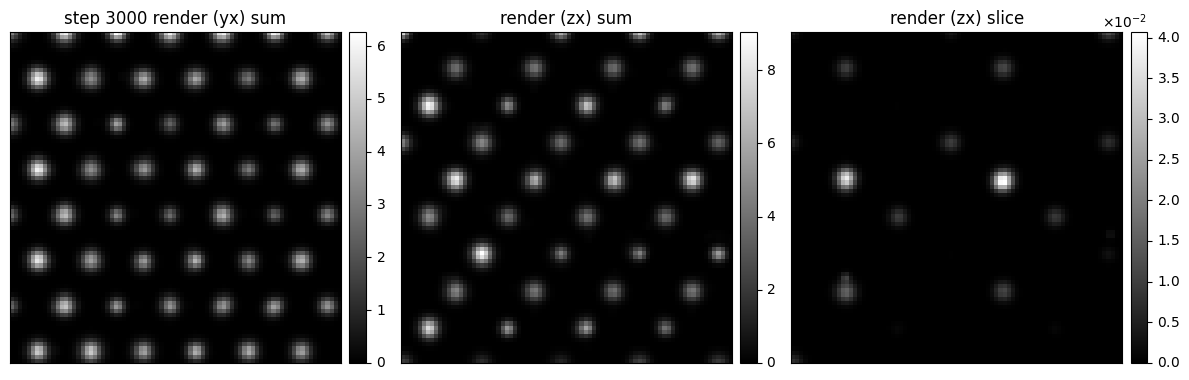

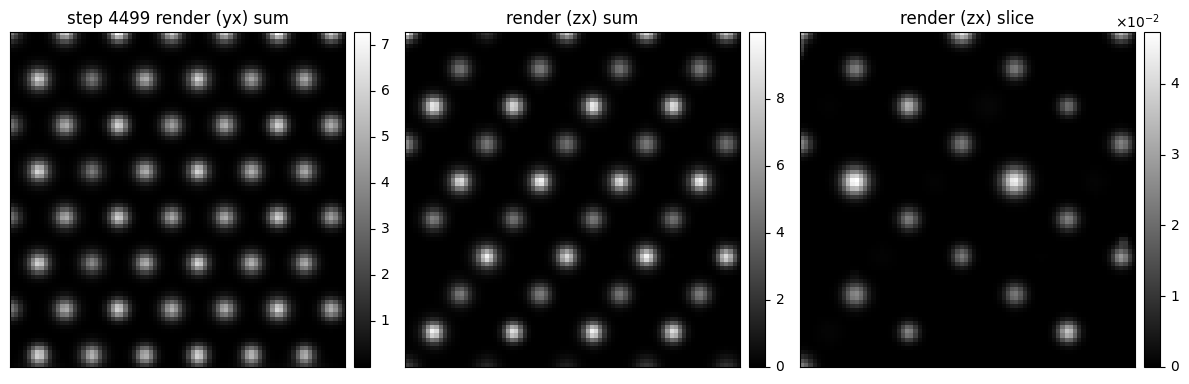

grads pos max: 4.75e-06, mean: 3.80e-07, min: 6.20e-11, std: 7.15e-07
grads_sigmas max: 4.68e-05, mean: 4.11e-06, min: 9.05e-09, std: 7.27e-06
grads ave max: 2.38e-05, mean: 2.24e-06, min: 6.34e-09, std: 3.79e-06
Step 4500 dupli/split: 1 GSs duplicated, 27 GSs split. Now have 407 GSs.
Step 4500 merge: 49 events | Now have 312 GSs.
Step 4500 pruned: total: 71 | intensity: 53 | big: 0 | small: 10 | xyz: 8
Step 4500 prune: 71 GSs | Now have 241 GSs.


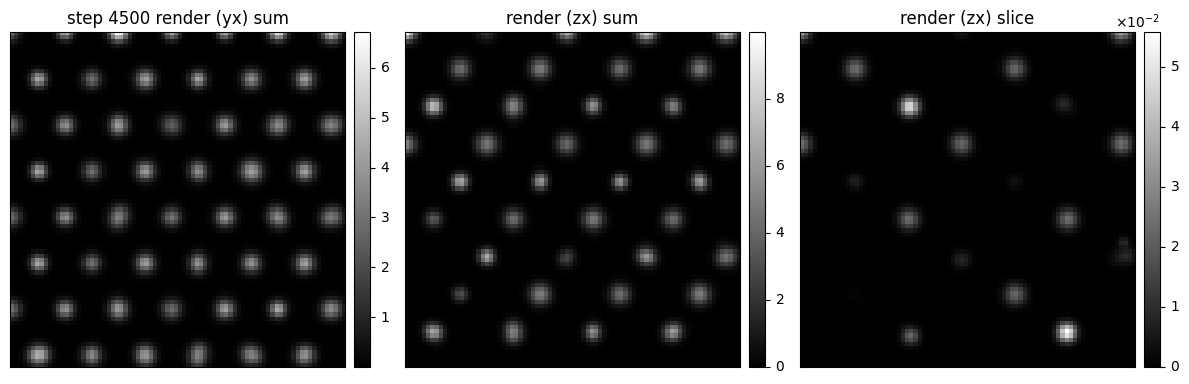

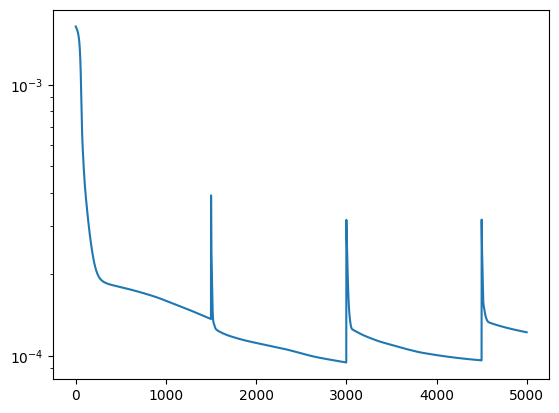

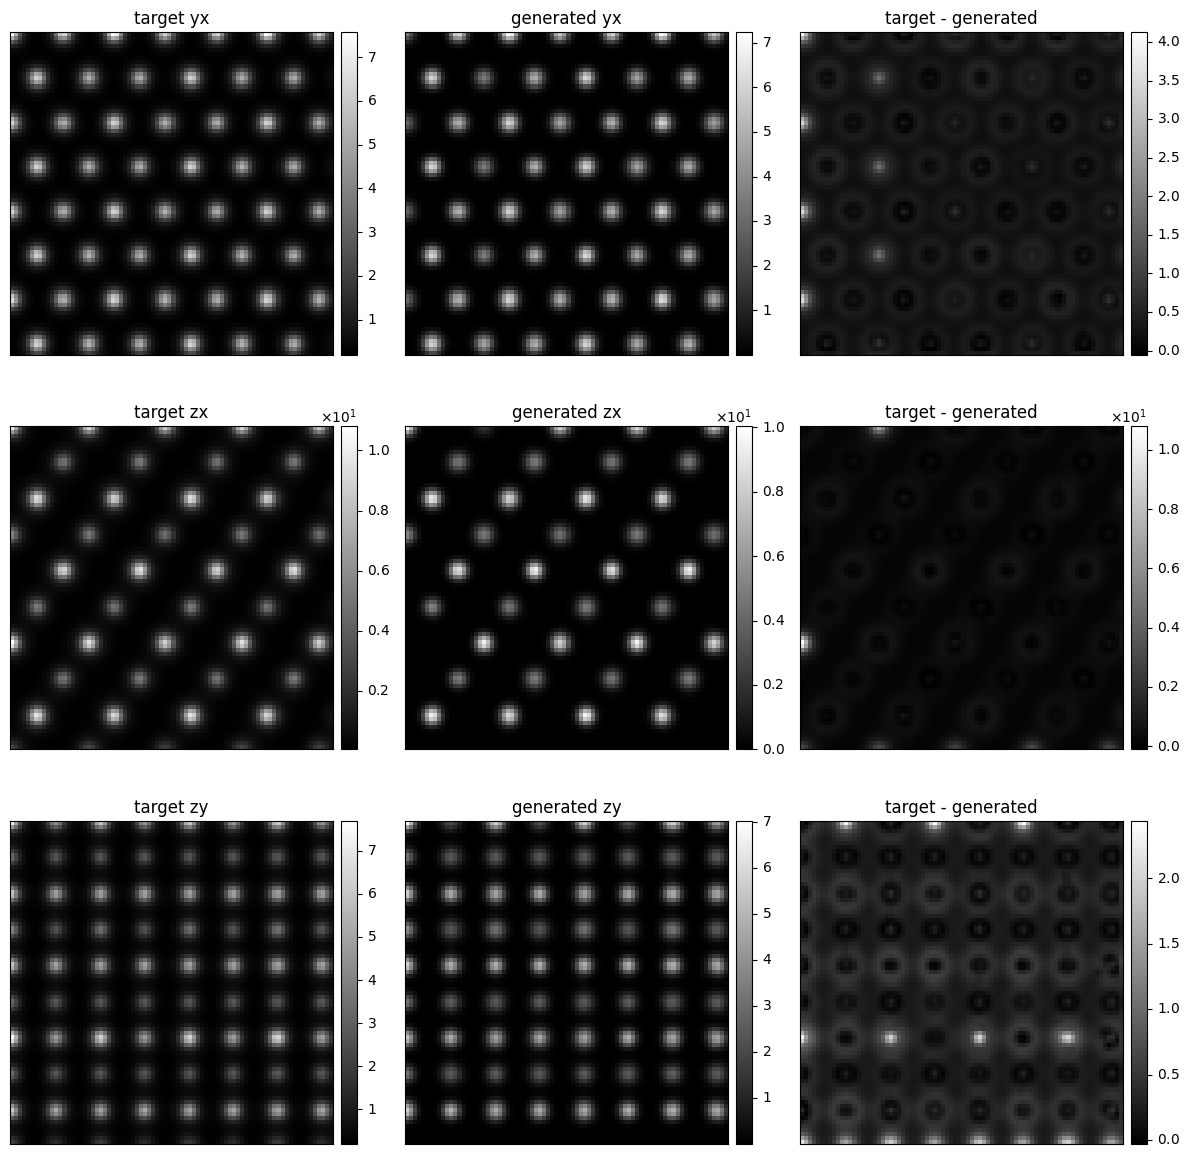

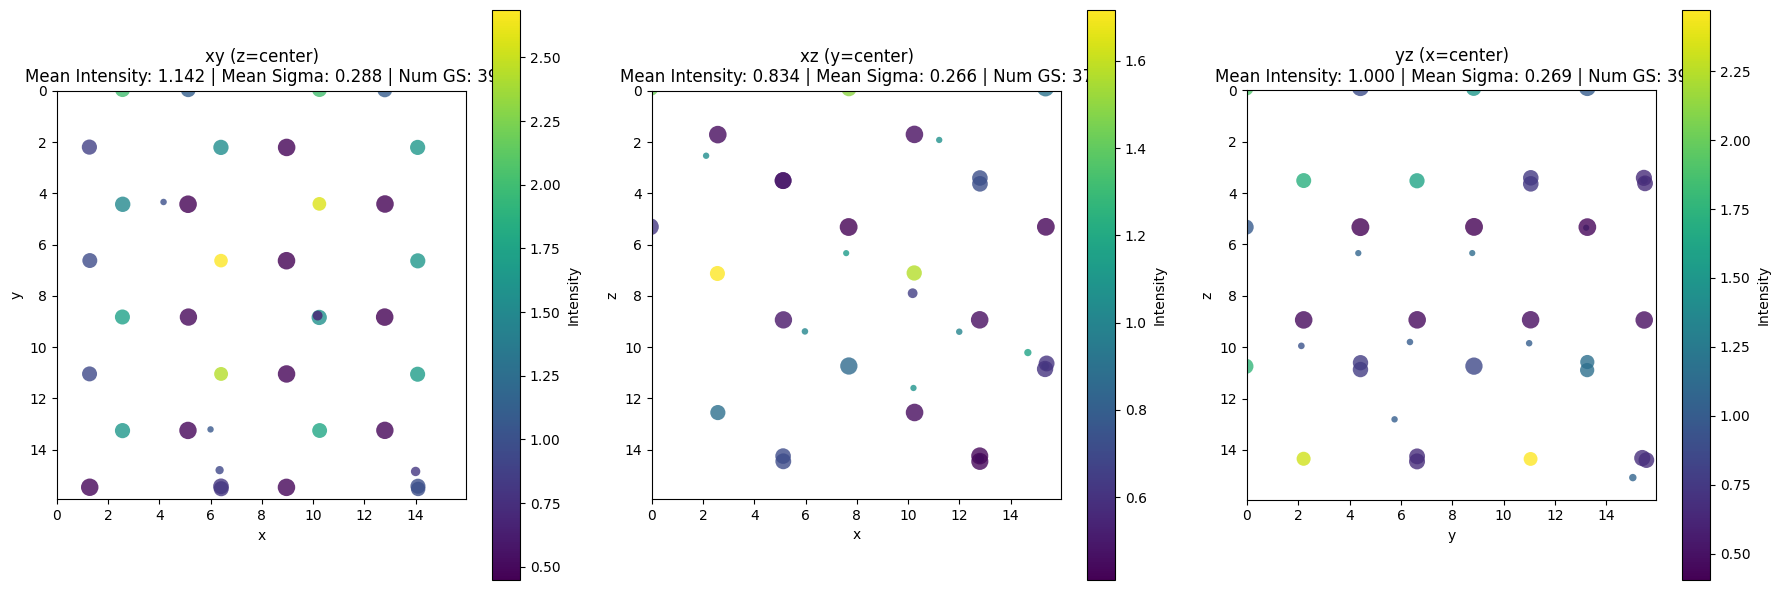

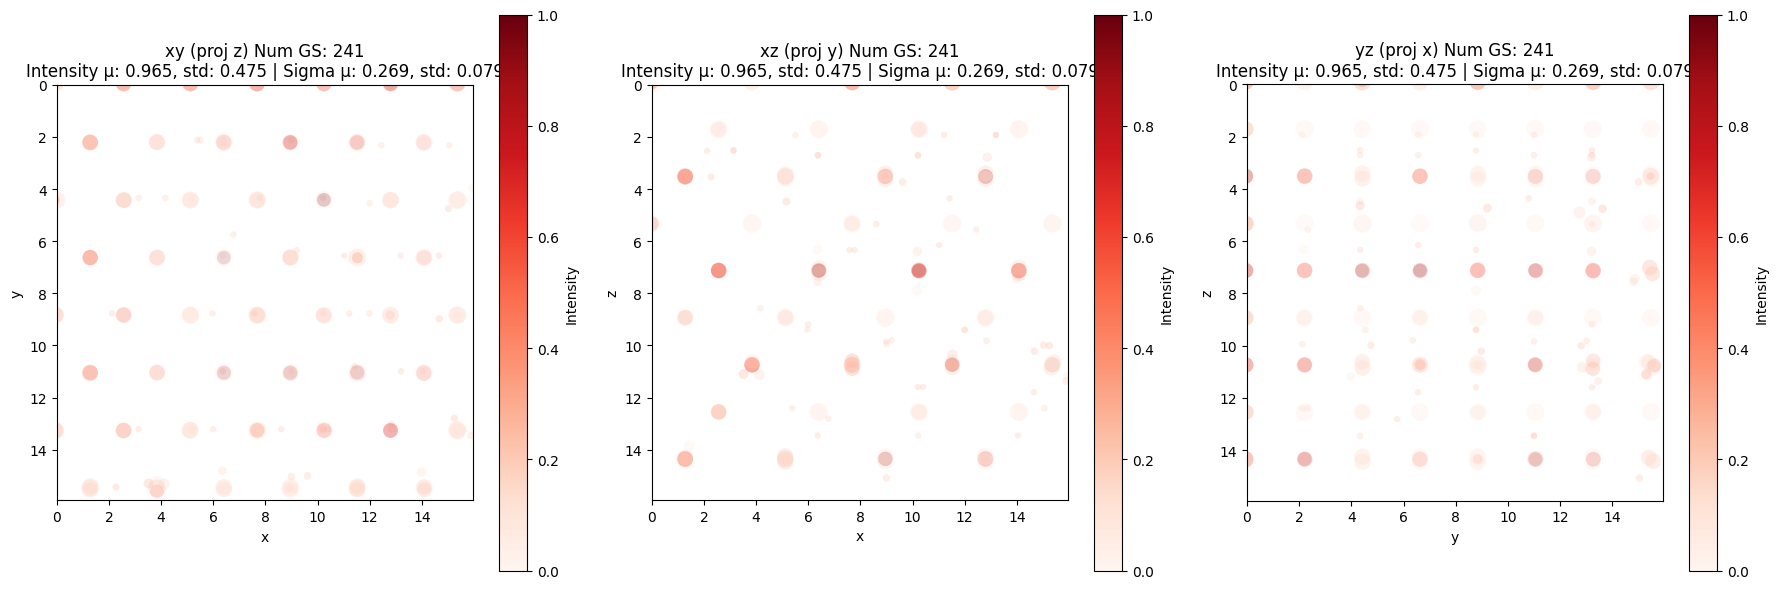

In [10]:
plt.close('all')
_cell = (potential.slice_thickness[0] * vol.shape[2], potential.sampling[1] * vol.shape[1], potential.sampling[0] * vol.shape[0])  # z,y,x

cfg = Config(
    model_type = '3dgs', 
    volume_size = _cell, 
    raster_shape=(vol.shape[0], vol.shape[1]),
    isotropic_splats=True,
    # 
    max_steps = 5_000, # 15_000, # 20_000,
    init_grid_sampling = 2.2, # 1.7, #  0.9, # A
    refine_start_iter = 1_000, # 5_000, 
    # refine_stop_iter = 16_000, 
    refine_every = 1_500, 
    reset_every = -1, 
    # add_start_iter = 15_000,
    # add_stop_iter = 15_500,
    lr_base = 0.01,  # 5e-3
    init_intensity= 1, # im.max(),
    init_sigma=0.2,
    prune_intensity_fac= 0.3, # 0.15,
    prune_sigma_big_A= 1., # 1
    prune_sigma_small_A =0.12, # 0.15
    prune_pad_A= 0.5,
    xy_merge_A = 0.1, # 0.25
    xy_merge_sigma_fac = 0.9, 
    split_dup_grad2d=1e-5, # 0.003,
    device=config.get("device"),
)

dset = SimpleVolumeDataset(vol)

gs = GS(
    cfg, 
)

pred, losses = gs.fit_volume(dset, max_steps=cfg.max_steps)

fig, ax = plt.subplots()
ax.semilogy(losses)
plt.show()


show_2d(
    [
        [vol.sum(0), pred.sum(0), vol.sum(0)-pred.sum(0)],
        [vol.sum(1), pred.sum(1), vol.sum(1)-pred.sum(1)],
        [vol.sum(2), pred.sum(2), vol.sum(2)-pred.sum(2)],
    ],
    title=[
        ['target yx', 'generated yx', 'target - generated'],
        ['target zx', 'generated zx', 'target - generated'],
        ['target zy', 'generated zy', 'target - generated'],
    ],
    cbar=True,
    norm='minmax',
);

gs.plot_gaussians_3d()
gs.plot_gaussians_3d(projected=True, alpha=0.2)


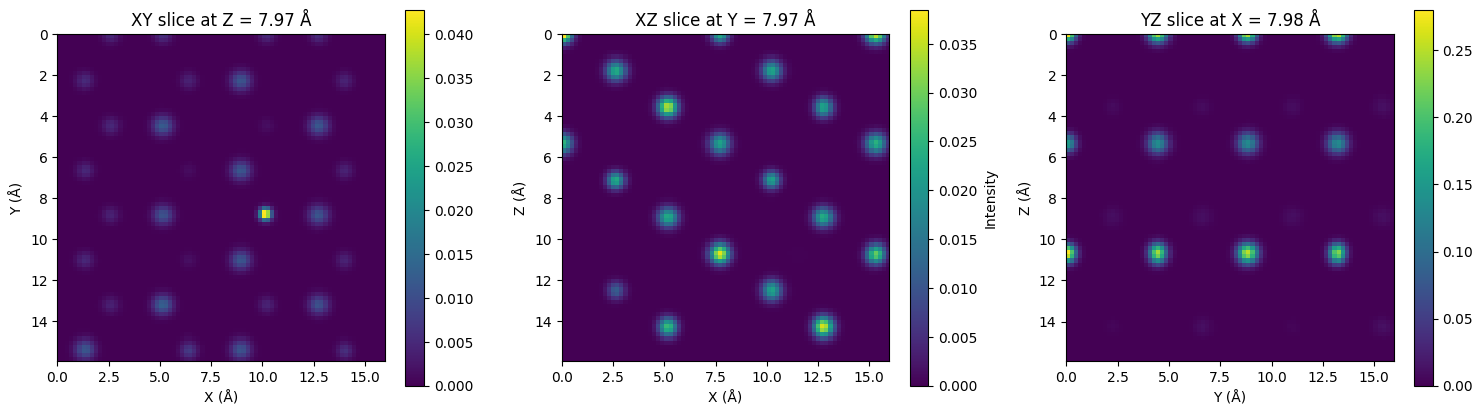

(<Figure size 1500x500 with 6 Axes>,
 array([<Axes: title={'center': 'XY slice at Z = 7.97 Å'}, xlabel='X (Å)', ylabel='Y (Å)'>,
        <Axes: title={'center': 'XZ slice at Y = 7.97 Å'}, xlabel='X (Å)', ylabel='Z (Å)'>,
        <Axes: title={'center': 'YZ slice at X = 7.98 Å'}, xlabel='Y (Å)', ylabel='Z (Å)'>],
       dtype=object))

In [11]:
gs.show_orthogonal_slices()

In [8]:
%matplotlib widget 

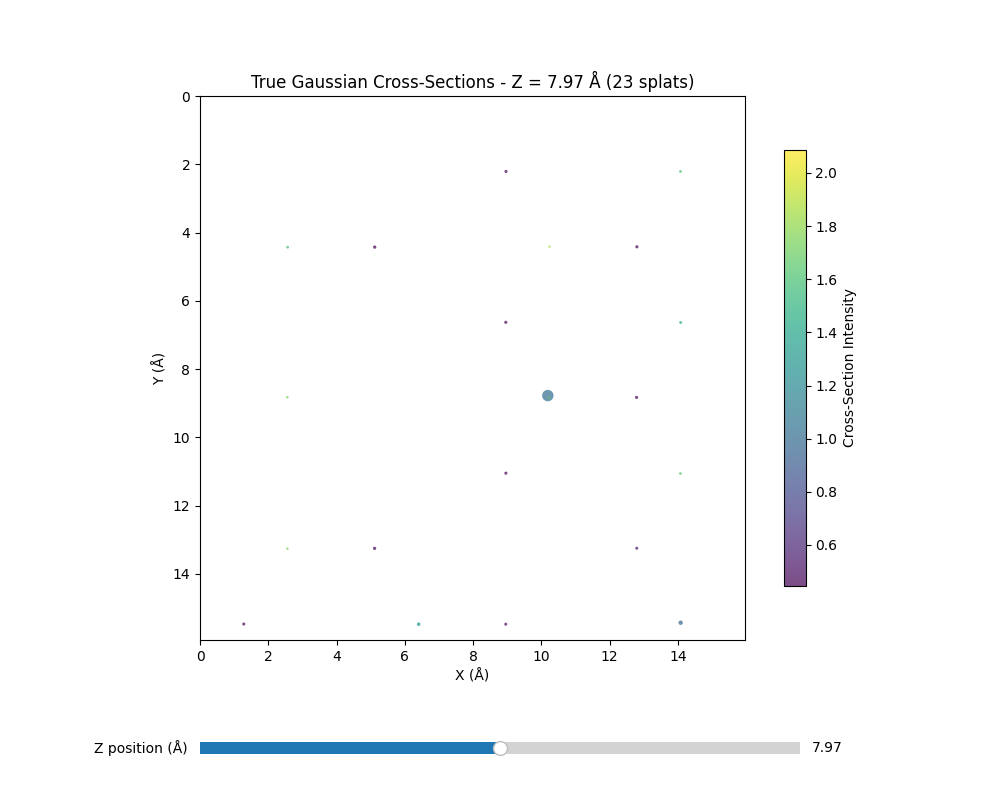

(<Figure size 1000x800 with 3 Axes>,
 <Axes: title={'center': 'True Gaussian Cross-Sections - Z = 7.97 Å (23 splats)'}, xlabel='X (Å)', ylabel='Y (Å)'>)

In [9]:
gs.show_slices()

# Volume tomo

## generating images

## splatting recon 